In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from analysis import get_feature_importances, wl_accuracy, season_record, runs_per_game, test_n
from data_format import create_data

In [2]:
version = 6
df = pd.read_csv(f'../data/baseball/training/game_data_v{version}.csv')

In [3]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(df, y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(df, y_col='home_score', split_by='season')

There is another problem with this random forest model, though. The output below shows how much each column is weighted when making predictions for how many runs the home team will score. We can see that, for example, `home_starter_xfip` is weighted at about 12% - but does the home team's starting *pitcher* really have that much effect on the home team's *batting* results? I tried to fine-tune the model by removing unnecessary or irrelevant features.

INITIAL FEATURE IMPORTANCES:


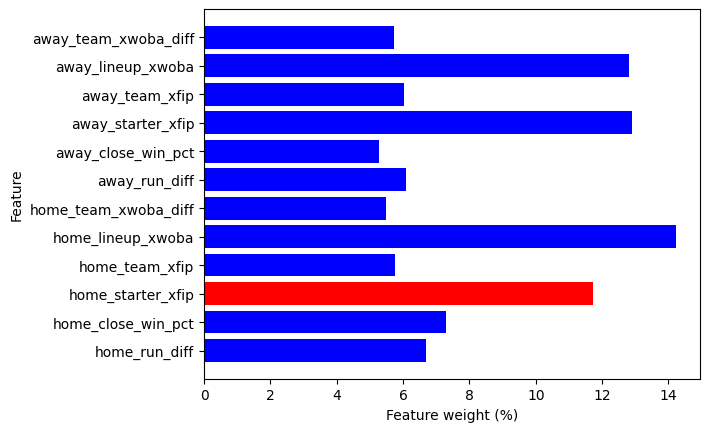

In [4]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

print('INITIAL FEATURE IMPORTANCES:')
feature_imp = get_feature_importances(x_test_home.columns, model_home)

plt.barh(feature_imp['feature'], feature_imp['weight'], align='center',
        color=['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b'])

plt.xlabel('Feature weight (%)')
plt.ylabel('Feature')

plt.gca().invert_yaxis()
plt.show()

In [5]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(df, drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'away_team_xfip', 'away_starter_xfip',
                                                                              'home_lineup_xwoba', 'home_run_diff'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(df, drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'home_team_xfip', 'home_starter_xfip',
                                                                              'away_lineup_xwoba', 'away_run_diff'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [6]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print('RANDOM FOREST REGRESSION MODEL (v3 - selecting features)')
print(f'Accuracy: {wl_accuracy(results)}%')

RANDOM FOREST REGRESSION MODEL (v3 - selecting features)
Accuracy: 54.93827160493827%


FINAL FEATURE IMPORTANCES:


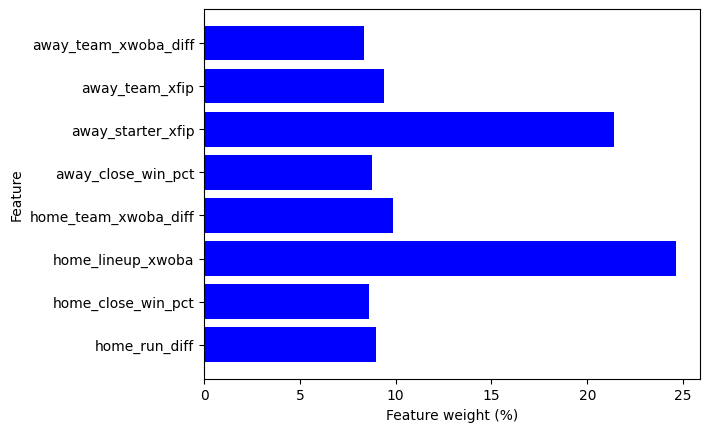

In [7]:
print('FINAL FEATURE IMPORTANCES:')
feature_imp = get_feature_importances(x_test_home.columns, model_home)

plt.barh(feature_imp['feature'], feature_imp['weight'], align='center', color='b')

plt.xlabel('Feature weight (%)')
plt.ylabel('Feature')

plt.gca().invert_yaxis()
plt.show()

                0
count  500.000000
mean    52.732593
std      0.999290
min     49.753086
25%     52.057613
50%     52.674897
75%     53.374486
max     56.255144


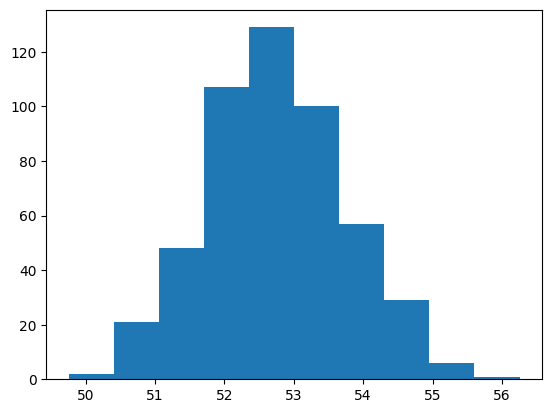

In [9]:
test_n(model_away, model_home, x_train_away, y_train_away, x_train_home, y_train_home, x_test_away, y_test_away, x_test_home, y_test_home, n_iter=500)

Now, `away_starter_xfip` and `home_lineup_xwoba` are weighted the most, which is more reasonable; the home team's lineup strength and the away team's starting pitcher should matter most when predicting the home team's runs scored.